In [20]:
import tensorflow as tf

In [29]:
if tf.test.is_gpu_available():
  device_name = tf.test.gpu_device_name()
else:
  device_name = '/CPU:0'
print(device_name)

/device:GPU:0


In [21]:
print('GPU avaialbale: ', tf.test.is_gpu_available())

GPU avaialbale:  True


In [22]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

**Adding transpose convolution layers in GENERATOR**

In [23]:
def make_dcgan_generator(
        z_size=20, 
        output_size=(28, 28, 1),
        n_filters=128, 
        n_blocks=2):
    size_factor = 2**n_blocks
    hidden_size = (
        output_size[0]//size_factor, 
        output_size[1]//size_factor
    )
    
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(z_size,)),
        
        tf.keras.layers.Dense(
            units=n_filters*np.prod(hidden_size), 
            use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape(
            (hidden_size[0], hidden_size[1], n_filters)),
    
        tf.keras.layers.Conv2DTranspose(
            filters=n_filters, kernel_size=(5, 5), strides=(1, 1),
            padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])
        
    nf = n_filters
    for i in range(n_blocks):
        nf = nf // 2
        model.add(
            tf.keras.layers.Conv2DTranspose(
                filters=nf, kernel_size=(5, 5), strides=(2, 2),
                padding='same', use_bias=False))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
                
    model.add(
        tf.keras.layers.Conv2DTranspose(
            filters=output_size[2], kernel_size=(5, 5), 
            strides=(1, 1), padding='same', use_bias=False, 
            activation='tanh'))
        
    return model

def make_dcgan_discriminator(
        input_size=(28, 28, 1),
        n_filters=64, 
        n_blocks=2):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_size),
        tf.keras.layers.Conv2D(
            filters=n_filters, kernel_size=5, 
            strides=(1, 1), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])
    
    nf = n_filters
    for i in range(n_blocks):
        nf = nf*2
        model.add(
            tf.keras.layers.Conv2D(
                filters=nf, kernel_size=(5, 5), 
                strides=(2, 2),padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(0.3))
        
    model.add(tf.keras.layers.Conv2D(
            filters=1, kernel_size=(7, 7), padding='valid'))
    
    model.add(tf.keras.layers.Reshape((1,)))
    
    return model

In [32]:
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'

In [25]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)


def preprocess(ex, mode='uniform'):
  image = ex['image']
  image=  tf.image.convert_image_dtype(image, tf.float32)

  image = image*2.0 - 1.0
  if mode == 'uniform':
    input_z = tf.random.uniform(shape=(z_size, ), minval=-1.0, maxval=1.0)
  elif mode == 'normal':
    input_z = tf.random.normal(shape=(z_size, ))
  
  return input_z, image

In [26]:
gen_model = make_dcgan_generator()
gen_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6272)              125440    
                                                                 
 batch_normalization_16 (Bat  (None, 6272)             25088     
 chNormalization)                                                
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 7, 7, 128)        409600    
 Transpose)                                                      
                                                                 
 batch_normalization_17 (Bat  (None, 7, 7, 128)       

In [27]:
disc_model = make_dcgan_discriminator()
disc_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        1664      
                                                                 
 batch_normalization_20 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 28, 28, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 128)       204928    
                                                                 
 batch_normalization_21 (Bat  (None, 14, 14, 128)      512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 14, 14, 128)      

**Implementing WGAN-GP to train DCGAN model**

In [31]:
num_epochs = 100
batch_size = 128
lambda_gp = 10.0

tf.random.set_seed(1)
np.random.seed(1)

# set-up the dataset
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(preprocess)

mnist_trainset = mnist_trainset.shuffle(10000).batch(batch_size, drop_remainder=True)

# set-up the model
with tf.device(device_name):
  gen_model = make_dcgan_generator()
  gen_model.build(input_shape=(None, z_size))

  disc_model = make_dcgan_discriminator()
  disc_model.build(input_shape=(None, np.prod(image_size)))

In [35]:
import time


## optimizers:
g_optimizer = tf.keras.optimizers.Adam(0.0002)
d_optimizer = tf.keras.optimizers.Adam(0.0002)

if mode_z == 'uniform':
    fixed_z = tf.random.uniform(
        shape=(batch_size, z_size),
        minval=-1, maxval=1)
elif mode_z == 'normal':
    fixed_z = tf.random.normal(
        shape=(batch_size, z_size))

def create_samples(g_model, input_z):
    g_output = g_model(input_z, training=False)
    images = tf.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

all_losses = []
epoch_samples = []

start_time = time.time()

for epoch in range(1, num_epochs+1):
    epoch_losses = []
    for i,(input_z,input_real) in enumerate(mnist_trainset):
        
        ## Compute discriminator's loss and gradients:
        with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
            g_output = gen_model(input_z, training=True)
            
            d_critics_real = disc_model(input_real, training=True)
            d_critics_fake = disc_model(g_output, training=True)

            ## Compute generator's loss:
            g_loss = -tf.math.reduce_mean(d_critics_fake)

            ## Compute discriminator's losses
            d_loss_real = -tf.math.reduce_mean(d_critics_real)
            d_loss_fake =  tf.math.reduce_mean(d_critics_fake)
            d_loss = d_loss_real + d_loss_fake

            ## Gradient penalty:
            with tf.GradientTape() as gp_tape:
                alpha = tf.random.uniform(
                    shape=[d_critics_real.shape[0], 1, 1, 1], 
                    minval=0.0, maxval=1.0)
                interpolated = (
                    alpha*input_real + (1-alpha)*g_output)
                gp_tape.watch(interpolated)
                d_critics_intp = disc_model(interpolated)
            
            grads_intp = gp_tape.gradient(
                d_critics_intp, [interpolated,])[0]
            grads_intp_l2 = tf.sqrt(
                tf.reduce_sum(tf.square(grads_intp), axis=[1, 2, 3]))
            grad_penalty = tf.reduce_mean(tf.square(grads_intp_l2 - 1.0))
        
            d_loss = d_loss + lambda_gp*grad_penalty
        
        ## Optimization: Compute the gradients apply them
        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))
        
        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))

        epoch_losses.append(
            (g_loss.numpy(), d_loss.numpy(), 
             d_loss_real.numpy(), d_loss_fake.numpy()))
                    
    all_losses.append(epoch_losses)
    
    print('Epoch {:-3d} | ET {:.2f} min | Avg Losses >>'
          ' G/D {:6.2f}/{:6.2f} [D-Real: {:6.2f} D-Fake: {:6.2f}]'
          .format(epoch, (time.time() - start_time)/60, 
                  *list(np.mean(all_losses[-1], axis=0)))
    )
    
    epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy()
    )

Epoch   1 | ET 1.64 min | Avg Losses >> G/D -2644.53/988.48 [D-Real: -3286.53 D-Fake: 2644.53]
Epoch   2 | ET 3.27 min | Avg Losses >> G/D -2287.67/306.67 [D-Real: -2412.17 D-Fake: 2287.67]
Epoch   3 | ET 4.90 min | Avg Losses >> G/D -2471.51/ 53.90 [D-Real: -2589.85 D-Fake: 2471.51]
Epoch   4 | ET 6.53 min | Avg Losses >> G/D -2620.36/  2.13 [D-Real: -2719.01 D-Fake: 2620.36]
Epoch   5 | ET 8.16 min | Avg Losses >> G/D -1854.05/3632.80 [D-Real: -1966.83 D-Fake: 1854.05]
Epoch   6 | ET 9.79 min | Avg Losses >> G/D -1452.87/264.14 [D-Real: -1468.52 D-Fake: 1452.87]
Epoch   7 | ET 12.15 min | Avg Losses >> G/D -1607.13/ 87.87 [D-Real: -1629.87 D-Fake: 1607.13]
Epoch   8 | ET 13.78 min | Avg Losses >> G/D -1740.76/ 13.57 [D-Real: -1766.22 D-Fake: 1740.76]
Epoch   9 | ET 15.41 min | Avg Losses >> G/D -1653.11/ 26.12 [D-Real: -1681.21 D-Fake: 1653.11]
Epoch  10 | ET 17.04 min | Avg Losses >> G/D -1744.85/ 81.11 [D-Real: -1781.45 D-Fake: 1744.85]
Epoch  11 | ET 18.67 min | Avg Losses >> G/D 

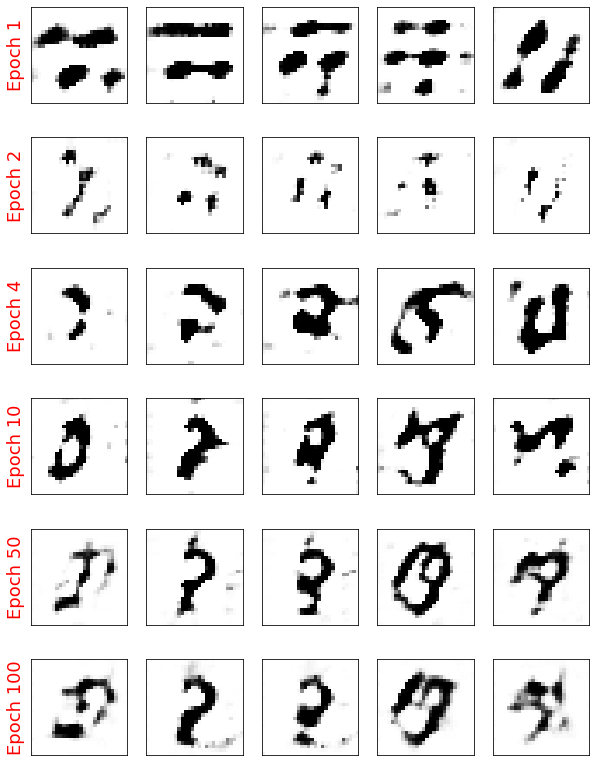

In [36]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
  for j in range(5):
    ax = fig.add_subplot(6, 5, i*5+j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
      ax.text(-0.06, 0.5, 'Epoch {}'.format(e),
              rotation=90, size=18, color='red',
              horizontalalignment='right',
              verticalalignment='center',
              transform=ax.transAxes)
    
    image = epoch_samples[e-1][j]
    ax.imshow(image, cmap='gray_r')
plt.show()